In [1]:
import tensorflow as tf

import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt

# Convert code as saved model

In [2]:
model = tf.keras.models.load_model('weights/mobilnet_hd_func.h5', compile=False)

In [3]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
outputs (Dense)              (None, 2)                 258       
Total params: 2,422,210
Trainable params: 164,226
Non-trainable params: 2,257,984
_________________________________________________________________


In [4]:
tf.saved_model.save(model, 'weights/mobilenet_hd')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: weights/mobilenet_hd/assets


# Load saved model

In [5]:
labels = {
    0: 'not hot dog',
    1: 'hot dog'
}

In [6]:
model = tf.saved_model.load('weights/mobilenet_hd/')

In [7]:
infer = model.signatures['serving_default']

In [8]:
images = glob.glob('data/test/**/*.jpg', recursive=True)

CPU times: user 1.44 s, sys: 344 ms, total: 1.79 s
Wall time: 1.4 s


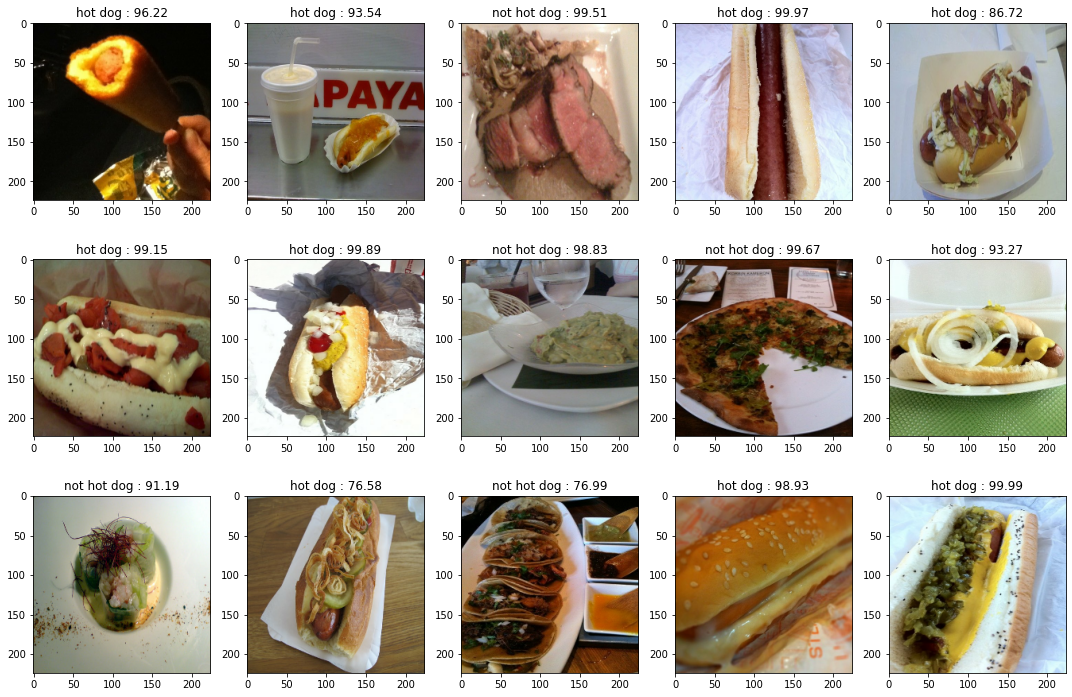

In [9]:
%%time
row, column, count = 3, 5, 0
plt.figure(figsize=(15, 10))

for image in np.random.choice(images, 15):
    img = tf.io.decode_jpeg(tf.io.read_file(image))
    img_pre = tf.cast(img, tf.float32) 
    img_pre = (img_pre / 127.5) - 1
    img_pre = tf.image.resize(img_pre, [224, 224])
    img_pre = tf.expand_dims(img_pre, axis=0)
    preds = infer(img_pre)['outputs']
    preds = tf.squeeze(preds, axis=0)
    
    label = labels[preds.numpy().argmax()]
    count += 1
    plt.subplot(row, column, count)
    plt.title(label + ' : ' + str(round(preds.numpy().max() * 100, 2)))
    img_ex = tf.squeeze(img_pre, axis=0)
    img_ex = (img_ex + 1) * 127.5
    plt.imshow(tf.cast(img_ex, tf.uint8))
    
plt.tight_layout()

# Save preprocessing as saved model

In [10]:
# @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None, 3], dtype=tf.uint8),))
# def preproc(img):
#     img = tf.cast(img, tf.float32) / 255.
#     img = tf.image.resize(img, [224, 224])
    
#     return img

class Preproc(tf.Module):
    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None, 3], dtype=tf.uint8),))
    def __call__(self, img):
        img = tf.cast(img, tf.float32)
        img = (img / 127.5) - 1.
        img = tf.image.resize(img, [224, 224])

        return img
    
preproc = Preproc()

In [11]:
tf.saved_model.save(preproc, 'weights/preproc')

INFO:tensorflow:Assets written to: weights/preproc/assets


In [12]:
preproc_model = tf.saved_model.load('weights/preproc/')

In [13]:
prepoc = preproc_model.signatures['serving_default']

CPU times: user 557 ms, sys: 84.2 ms, total: 641 ms
Wall time: 452 ms


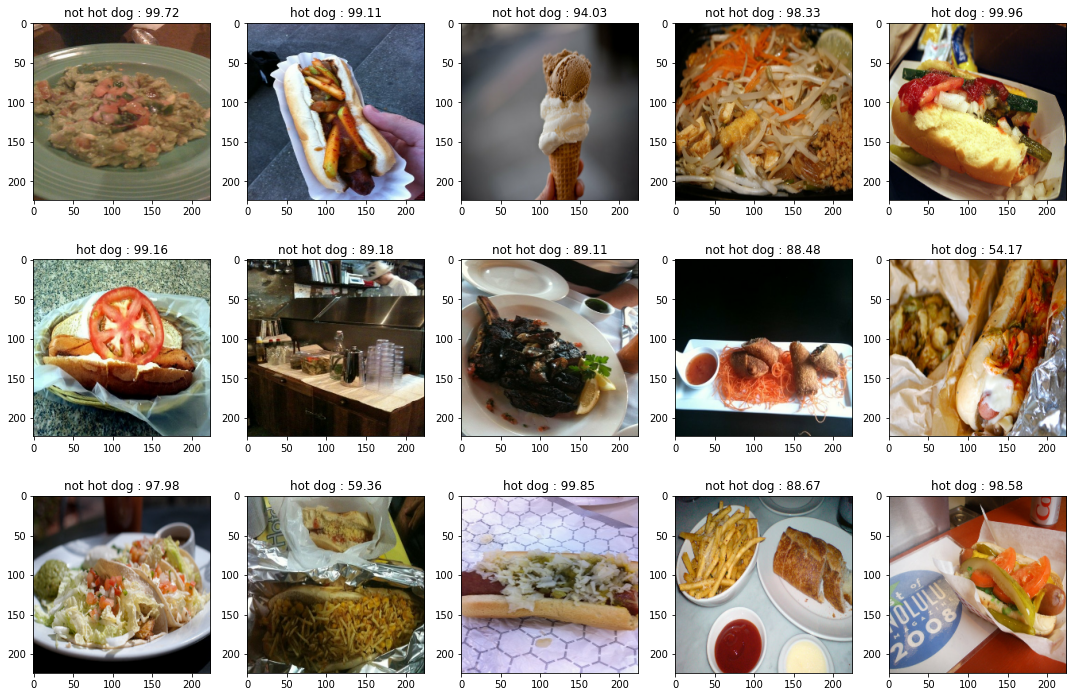

In [16]:
%%time
row, column, count = 3, 5, 0
plt.figure(figsize=(15, 10))
for image in np.random.choice(images, 15):
    img = tf.io.decode_jpeg(tf.io.read_file(image))
    
    img_pre = preproc(tf.expand_dims(img, axis=0))
    preds = infer(img_pre)['outputs']
    preds = tf.squeeze(preds, axis=0)
    
    label = labels[preds.numpy().argmax()]
    count += 1
    plt.subplot(row, column, count)
    plt.title(label + ' : ' + str(round(preds.numpy().max() * 100, 2)))
    img_ex = tf.squeeze(img_pre, axis=0)
    img_ex = (img_ex + 1) * 127.5
    plt.imshow(tf.cast(img_ex, tf.uint8))
    
plt.tight_layout()